In [42]:
#!pip install tqdm
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!

In [43]:
#define model_parameters
input_size=28
num_classes=10
learning_rate=0.001
batch_size=64
num_epochs=3
num_layers=2
hidden_size=256
sequence_length=28
#setup device
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [44]:
#Load The Data
train_data=datasets.MNIST(root='dataset/',train=True,transform=transforms.ToTensor(),download=True)
test_data=datasets.MNIST(root='dataset/',train=False,transform=transforms.ToTensor(),download=True)
train_loader=DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True)
test_loader=DataLoader(dataset=test_data,batch_size=batch_size,shuffle=True)

In [45]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,num_classes):
        super(RNN,self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.rnn=nn.RNN(input_size,hidden_size,num_layers,batch_first=True) #(batch_size,time_seq,features)
        self.fcc=nn.Linear(hidden_size*sequence_length,num_classes)
    def forward(self,x):
        h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
        out,_=self.rnn(x,h0)
        out=out.reshape(out.shape[0],-1)
        out=self.fcc(out)
        return out

In [46]:
model=RNN(input_size,hidden_size,num_layers,num_classes).to(device)
print(model)

RNN(
  (rnn): RNN(28, 256, num_layers=2, batch_first=True)
  (fcc): Linear(in_features=7168, out_features=10, bias=True)
)


In [47]:
##Helper Fuction to plot Images
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

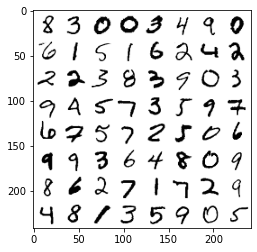

In [48]:
##Visualize through Tensorboard
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/digit_mnist')
dataiter = iter(train_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('digit_mnist_64', img_grid)

In [49]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)

for epoch in range(num_epochs):
    for batch_idx,(data,targets) in enumerate(train_loader):
        data=data.to(device=device).squeeze(1)
        targets=targets.to(device=device)
        
        scores=model(data)
        loss=criterion(scores,targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(epoch,"Completed")

0 Completed
1 Completed
2 Completed


In [50]:
def check_acc(loader,model):
    #initialize the accuracy testing variables
    correct=0
    samples=0
    #set the model to evaluation stage
    model.eval() 
    with torch.no_grad():
        for x,y in loader:
            x=x.to(device=device).squeeze(1)
            y=y.to(device=device)
            
            scores=model(x)
            _,predictions=scores.max(1)
            correct += (predictions == y).sum()
            samples += predictions.size(0)
    model.train()
    return correct/samples

In [51]:
check_acc(train_loader,model)

tensor(0.9685, device='cuda:0')

In [55]:
##Visualize model in Tensorboard
dataiter = iter(train_loader)
images, labels = dataiter.next()
images=images.to(device=device).squeeze(1)
writer.add_graph(model,images)
writer.close()